# Gravitationspotential


## Plot des Gravitationspotentials

In [104]:
import numpy as np
import matplotlib.pyplot as plt
import pandas

In [105]:
G = 0.0000000000667428 # in Nm^2 * kg^-2
R_e = 6371 * 10**3 # in m

prel_earth_ref_mod = pandas.read_csv("Data/preliminary_earth_reference_model.csv")
prel_earth_ref_mod *= 10**3 # all values in m or kg/m^3

In [106]:
def potential_integration_inner(R, B, C, D, E):
    return B * R**2 / 2 + C * R**3 / (3 * R_e) + D * R**4 / (4 * R_e**2) + E * R**5 / (5 * R_e**3)

def potential_integration_outer(R, B, C, D, E):
    return B * R**3 / 3 + C * R**4 / (4 * R_e) + D * R**5 / (5 * R_e**2) + E * R**6 / (6 * R_e**3)

In [107]:
def g_potential_inner(R_lower, R_upper, B, C, D, E):
    lower = potential_integration_inner(R_lower, B, C, D, E)
    upper = potential_integration_inner(R_upper, B, C, D, E)

    return 4 * np.pi * G * (upper - lower)

def g_potential_outer(R_lower, R_upper, d, B, C, D, E):
    lower = potential_integration_outer(R_lower, B, C, D, E)
    upper = potential_integration_outer(R_upper, B, C, D, E)

    return 4 * np.pi * G * (upper - lower) / d

g_potential_outer(1, 2,7,3,4,5,6)

8.387150427380733e-10

In [109]:
potential_per_shell = []
for index in prel_earth_ref_mod.index:
    R_lower = prel_earth_ref_mod.rmin[index]
    R_upper = prel_earth_ref_mod.rmax[index]

    B = prel_earth_ref_mod.B[index] 
    C = prel_earth_ref_mod.C[index]
    D = prel_earth_ref_mod.D[index]
    E = prel_earth_ref_mod.E[index]
    
    potential_per_shell.append(g_potential_inner(R_lower, R_upper, B, C, D, E))

prel_earth_ref_mod["potential_per_shell_in_middle"] = potential_per_shell
del potential_per_shell

#print(sum(prel_earth_ref_mod["potential_per_shell"]))

In [116]:
d = range(0, 4000000 * 10^3, 100000)
potential = []

for distance in d:
    pot_per_distance = 0

    for index in prel_earth_ref_mod.index:
        R_lower = prel_earth_ref_mod.rmin[index]
        R_upper = prel_earth_ref_mod.rmax[index]

        B = prel_earth_ref_mod.B[index]
        C = prel_earth_ref_mod.C[index]
        D = prel_earth_ref_mod.D[index]
        E = prel_earth_ref_mod.E[index]

        if distance > R_upper:
            pot_per_distance += g_potential_outer(R_lower, R_upper, distance, B, C, D, E,)
        elif distance <= R_lower:
            pot_per_distance += g_potential_inner(R_lower, R_upper, B, C, D, E)
        else: pot_per_distance += g_potential_inner(distance, R_upper, B, C, D, E) + g_potential_outer(R_lower, distance, distance, B, C, D, E,)
    
    potential.append(pot_per_distance)

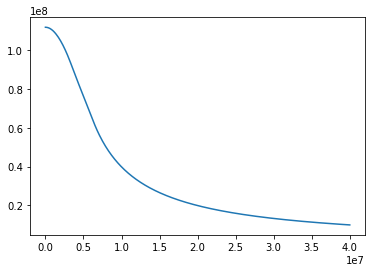

In [117]:
plt.plot(d, potential)

In [132]:
d = range(0, 4000000 * 10^3, 10000)
acc = []

for distance in d:
    pot_per_distance = 0

    for index in prel_earth_ref_mod.index:
        R_lower = prel_earth_ref_mod.rmin[index]
        R_upper = prel_earth_ref_mod.rmax[index]

        B = prel_earth_ref_mod.B[index]
        C = prel_earth_ref_mod.C[index]
        D = prel_earth_ref_mod.D[index]
        E = prel_earth_ref_mod.E[index]

        if distance > R_upper:
            pot_per_distance += g_potential_outer(R_lower, R_upper, distance**2, B, C, D, E,)
        elif distance <= R_lower:
            pot_per_distance += 0
        else: pot_per_distance += g_potential_outer(R_lower, distance, distance**2, B, C, D, E,)
    
    acc.append(pot_per_distance)

Text(0.5, 0.5, '10.69')

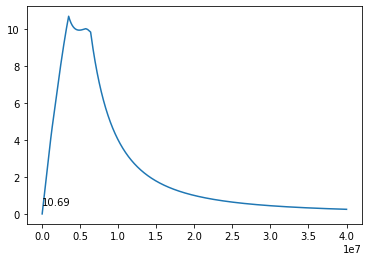

In [133]:
plt.plot(d, acc)
plt.annotate(round(max(acc), 2),(0.5,0.5))